<a href="https://colab.research.google.com/github/selimunal/Pytorch/blob/main/Recommender_Systems_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2023-02-15 09:39:20--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  49.1MB/s    in 4.1s    

2023-02-15 09:39:25 (46.0 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


In [ ]:
df=pd.read_csv("ml-20m/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
df2=pd.read_csv("ml-20m/genome-scores.csv")
df2.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [ ]:
df3=pd.read_csv("ml-20m/links.csv")
df3.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
df.userId=pd.Categorical(df.userId)
df["new_user_id"]=df.userId.cat.codes

In [ ]:
df.head(), df.tail()

(  userId  movieId  rating   timestamp  new_user_id
 0      1        2     3.5  1112486027            0
 1      1       29     3.5  1112484676            0
 2      1       32     3.5  1112484819            0
 3      1       47     3.5  1112484727            0
 4      1       50     3.5  1112484580            0,
           userId  movieId  rating   timestamp  new_user_id
 20000258  138493    68954     4.5  1258126920       138492
 20000259  138493    69526     4.5  1259865108       138492
 20000260  138493    69644     3.0  1260209457       138492
 20000261  138493    70286     5.0  1258126944       138492
 20000262  138493    71619     2.5  1255811136       138492)

In [ ]:
df.movieId=pd.Categorical(df.movieId)
df["new_movie_id"]=df.movieId.cat.codes
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [ ]:
#get user Ids movie IDs and ratings as seperate arrays
user_ids=df["new_user_id"].values
movie_ids=df["new_movie_id"].values
ratings=df["rating"].values-2.5

In [ ]:
#get number of users and number of movies
N=len(set(user_ids))
M=len(set(movie_ids))
N , M

(138493, 26744)

In [ ]:
#set embedding dimension
D=10

In [ ]:
#make a NN
class Model(nn.Module):
  def __init__(self,n_users,n_items,embed_dim,n_hidden=1024):
    super(Model, self).__init__()
    self.N=n_users
    self.M=n_items
    self.D=embed_dim

    self.u_emb=nn.Embedding(self.N,self.D)
    self.m_emb=nn.Embedding(self.M,self.D)
    self.fc1=nn.Linear(2*self.D,n_hidden)
    self.fc2=nn.Linear(n_hidden,1)

  def forward(self, u, m):
    u=self.u_emb(u) #output is (num_samples,D)
    m=self.m_emb(m) #output is (num_samples, D)

    #merge
    out=torch.cat((u,m),1) # output is (num_samples,2D)

    #ANN
    out=self.fc1(out)
    out=F.relu(out)
    out=self.fc2(out)
    return out

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model=Model(N,M,D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
#loss and optimizer
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters())
#optimizer=torch.optim.SGD(model.paratemeters(),lr=0.8,momentum=0.9)

In [ ]:
#shuffke the data in corresponding order
user_ids, movie_ids, ratings=shuffle(user_ids,movie_ids, ratings)

In [ ]:
#convert to tensors
user_ids_t=torch.from_numpy(user_ids).long()
movie_ids_t=torch.from_numpy(movie_ids).long()
ratings_t=torch.from_numpy(ratings)

In [ ]:
#make datasets
Ntrain=int(0.8*len(ratings))
train_dataset=torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain],
)

test_dataset=torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:],
)

In [ ]:
#data loadders
batch_size=512
train_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
#an function to encap the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)

  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for users, movies, targets in train_loader:
      targets=targets.view(-1,1).float()

      #move data to GPU
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)

      #zro the optimizer
      optimizer.zero_grad()

      #forward pass
      outputs=model(users,movies)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    #get train loss and test loss
    train_loss=np.mean(train_loss)

    test_loss=[]

    for users, movies, targets in test_loader:
      #move data to GPU
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)
      targets=targets.view(-1,1).float()
    
      #forward pass
      outputs=model(users,movies)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      test_loss.append(loss.item())
    
    #get train loss and test loss
    test_loss=np.mean(test_loss)

    #save losses
    train_losses[it]=train_loss
    test_losses[it]=test_loss



    print(f"epoch {it+1}/{epochs}, train loss:{train_loss:.4f}",
          f"test loss {test_loss:.4f}")
    
  return train_losses, test_losses



In [ ]:
%prun train_losses, test_losses=batch_gd( \
    model, criterion, optimizer, train_loader, test_loader, 25)

epoch 1/25, train loss:0.8170 test loss 93651.2708
epoch 2/25, train loss:246455.5133 test loss 290998.5064
epoch 3/25, train loss:1056107.5950 test loss 3858220.0657
epoch 4/25, train loss:23277776.6880 test loss 26919828.6035
epoch 5/25, train loss:54016129.7740 test loss 26626846.4449
epoch 6/25, train loss:20415075.1703 test loss 14865865.5611
epoch 7/25, train loss:10040242.4726 test loss 8624763.6201
epoch 8/25, train loss:99349166.6248 test loss 96538816.2645
epoch 9/25, train loss:1617145.0249 test loss 1450841.4101
epoch 10/25, train loss:14.7294 test loss 10.6264
epoch 11/25, train loss:1.1100 test loss 1.1601
epoch 12/25, train loss:1.1278 test loss 1.1606
epoch 13/25, train loss:1.1265 test loss 1.1602
epoch 14/25, train loss:1.1280 test loss 1.1602
epoch 15/25, train loss:1.1280 test loss 1.1603
epoch 16/25, train loss:1.1257 test loss 1.1602
epoch 17/25, train loss:1.1278 test loss 1.1604
epoch 18/25, train loss:1.1276 test loss 1.1602
epoch 19/25, train loss:1.1276 test 

NameError: ignored

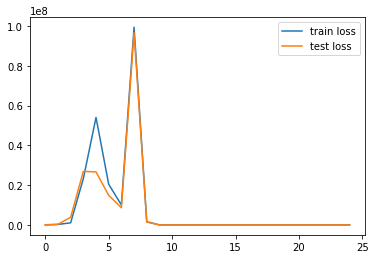

In [ ]:
# plot loss per iteration
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

# Modified version of Recommenders code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
#make a NN
class Model(nn.Module):
  def __init__(self,n_users,n_items,embed_dim,n_hidden=1024):
    super(Model, self).__init__()
    self.N=n_users
    self.M=n_items
    self.D=embed_dim

    self.u_emb=nn.Embedding(self.N,self.D)
    self.m_emb=nn.Embedding(self.M,self.D)
    self.fc1=nn.Linear(2*self.D,n_hidden)
    self.fc2=nn.Linear(n_hidden,1)

    #set weights since N(0,1) leads to poor results

    self.u_emb.weight.data=nn.Parameter(
        torch.Tensor(np.random.randn(self.N,self.D)*0.01)
    )
    self.m_emb.weight.data=nn.Parameter(
        torch.Tensor(np.random.randn(self.M,self.D)*0.01)
    )

  def forward(self, u, m):
    u=self.u_emb(u) #output is (num_samples,D)
    m=self.m_emb(m) #output is (num_samples, D)

    #merge
    out=torch.cat((u,m),1) # output is (num_samples,2D)

    #ANN
    out=self.fc1(out)
    out=F.relu(out)
    out=self.fc2(out)
    return out

In [ ]:
#an function to encap the training loop
def batch_gd2(model, criterion, optimizer, train_data, test_data,epochs, bs=512):
  train_users, train_movies, train_ratings=train_data
  test_users, test_movies, test_ratings=test_data

  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  #batches per epoch
  Ntrain=len(train_users)
  batches_per_epoch=int(np.ceil(Ntrain/bs))

  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]

    #shuffle each batch
    train_users, train_movies, train_ratings= shuffle(
        train_users, train_movies,train_ratings
    )



    for j in range(batches_per_epoch):
      users=train_users[j*bs:(j+1)*bs]
      movies=train_movies[j*bs:(j+1)*bs]
      targets=train_ratings[j*bs:(j+1)*bs]

      #convert to tensor
      users=torch.from_numpy(users).long()
      movies=torch.from_numpy(movies).long()
      targets=torch.from_numpy(targets)
     
      targets=targets.view(-1,1).float()

      #move data to GPU
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)

      #zro the optimizer
      optimizer.zero_grad()

      #forward pass
      outputs=model(users,movies)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    #get train loss and test loss
    train_loss=np.mean(train_loss)

    test_loss=[]

    for j in range(int(np.ceil(len(test_users)/bs))):

      users=train_users[j*bs:(j+1)*bs]
      movies=train_movies[j*bs:(j+1)*bs]
      targets=train_ratings[j*bs:(j+1)*bs]

      #convert to tensor
      users=torch.from_numpy(users).long()
      movies=torch.from_numpy(movies).long()
      targets=torch.from_numpy(targets)

      #move data to GPU
      users, movies, targets=users.to(device), movies.to(device), targets.to(device)
      targets=targets.view(-1,1).float()
    
      #forward pass
      outputs=model(users,movies)
      loss=criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      test_loss.append(loss.item())
    
    #get train loss and test loss
    test_loss=np.mean(test_loss)

    #save losses
    train_losses[it]=train_loss
    test_losses[it]=test_loss



    print(f"epoch {it+1}/{epochs}, train loss:{train_loss:.4f}",
          f"test loss {test_loss:.4f}")
    
  return train_losses, test_losses



In [ ]:
#shuffke the data in corresponding order
user_ids, movie_ids, ratings=shuffle(user_ids, movie_ids,ratings)

In [ ]:
#make datasets
Ntrain=int(0.8*len(ratings))
train_users=user_ids[:Ntrain]
train_movies=movie_ids[:Ntrain]
train_ratings=ratings[:Ntrain]

test_users=user_ids[Ntrain:]
test_movies=movie_ids[Ntrain:]
test_ratings=ratings[Ntrain:]

train_losses, test_losses=batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10
)

epoch 1/10, train loss:0.7271 test loss 1715.2385
epoch 2/10, train loss:1495.9709 test loss 8966.0168
epoch 3/10, train loss:4745.8130 test loss 49135.3399
epoch 4/10, train loss:7310.5154 test loss 9797.6144
epoch 5/10, train loss:6223.0243 test loss 8066.9924
